In [18]:
import torch
import dataset
import models
import utils
import visual
import gradcam
import numpy as np
from torchvision import transforms
from train_test import train, test, train_ocp
import albumentations as A
from albumentations.pytorch import ToTensor
import numpy

In [3]:
cuda, device = utils.misc.initialize_device(utils.config.SEED)

GPU Available? True


In [4]:
utils.config.BATCH_SIZE = 128

In [5]:
trainset = dataset.pytorch_datasets(True, True, dataset_name='cifar10')
testset = dataset.pytorch_datasets(False, True, dataset_name='cifar10')

Files already downloaded and verified
Files already downloaded and verified


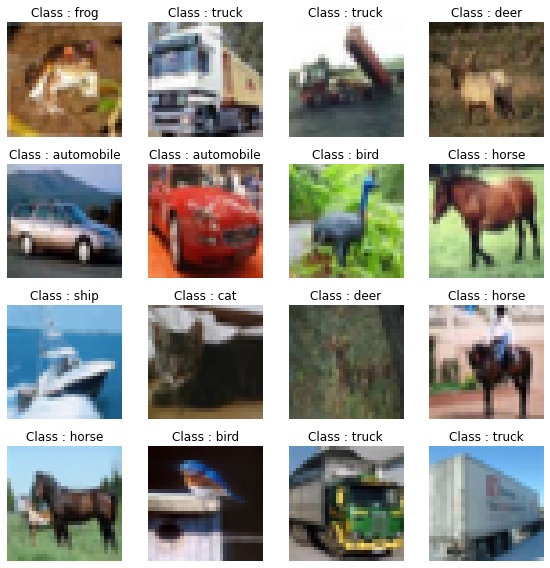

In [8]:
visual.visualization.show_imgs(trainset, 16, (8, 8))

In [6]:
mean, std = dataset.img_reg.get_stats(trainset)[0], dataset.img_reg.get_stats(trainset)[1]
print(mean, std)

(0.4914, 0.4822, 0.4465) (0.247, 0.2435, 0.2616)


In [7]:
transformations_list = [A.Normalize(mean, std)]
augmentations_list = [A.RandomCrop(32,32),
                      A.HorizontalFlip(), 
                      A.Rotate(limit=15),
                      A.Cutout(1, 8, 8, fill_value=mean, p=0.5),
                     ]
# augmentations_list = []

In [8]:
trainset = dataset.pytorch_datasets(True, True, transformations_list, augmentations_list, dataset_name='cifar10')
testset = dataset.pytorch_datasets(False, True, transformations_list, dataset_name='cifar10')
train_dl = dataset.data_loader(trainset, utils.config.BATCH_SIZE, utils.config.NUM_WORKERS, cuda, shuffle=True)
test_dl = dataset.data_loader(testset, utils.config.BATCH_SIZE, utils.config.NUM_WORKERS, cuda, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


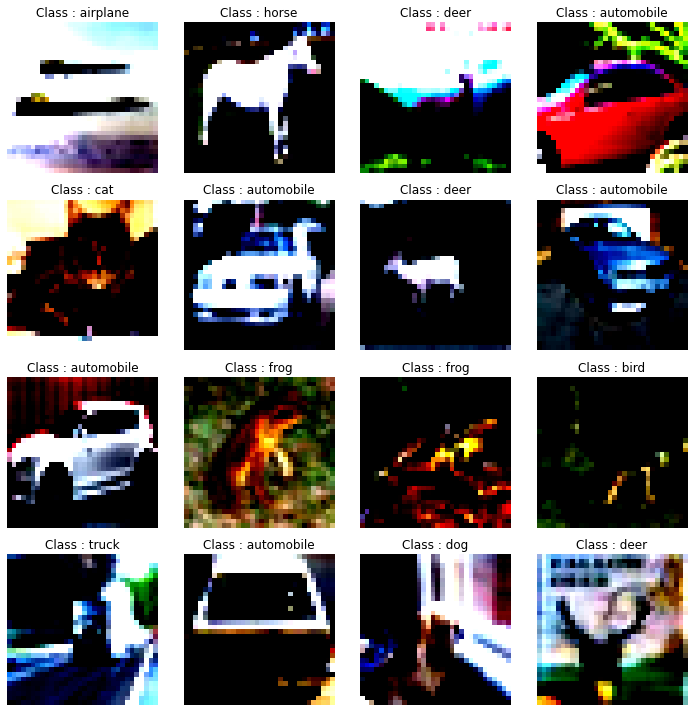

In [16]:
visual.visualization.show_batch(train_dl)

In [9]:
#Define model
model = models.A11().to(device)

In [10]:
utils.misc.summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
           Dropout-4           [-1, 64, 32, 32]               0
            Conv2d-5          [-1, 128, 32, 32]          73,728
         MaxPool2d-6          [-1, 128, 16, 16]               0
       BatchNorm2d-7          [-1, 128, 16, 16]             256
              ReLU-8          [-1, 128, 16, 16]               0
           Dropout-9          [-1, 128, 16, 16]               0
           Conv2d-10          [-1, 128, 16, 16]         147,456
      BatchNorm2d-11          [-1, 128, 16, 16]             256
             ReLU-12          [-1, 128, 16, 16]               0
          Dropout-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 128,

In [11]:
utils.config.EPOCHS = 10

In [12]:
model = models.ResNet18().to(device)
loss_fn = utils.misc.cross_entropy_loss_fn()
optimizer = utils.misc.sgd_optimizer(model,lr=0.0001)

In [13]:
lr_finder = utils.lr_finder.LRFinder(model, optimizer, loss_fn, device=device)
lr_finder.range_test(train_dl, end_lr=100, num_iter=100)

Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()


LR suggestion: steepest gradient
Suggested LR: 2.01E+00


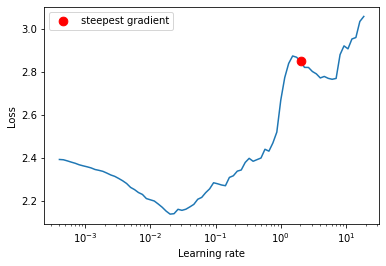

(<AxesSubplot:xlabel='Learning rate', ylabel='Loss'>, 2.009233002565046)

In [14]:
lr_finder.plot()

In [15]:
lr_finder.reset()

In [20]:
utils.config.EPOCHS = 4

In [21]:
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, OneCycleLR
model = models.A11().to(device)
loss_fn = utils.misc.cross_entropy_loss_fn()
optimizer = utils.misc.sgd_optimizer(model)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_dl), final_div_factor=5,epochs=4)
if utils.config.DEBUG == True:
    utils.config.EPOCHS = 15

test_loss = []
test_accuracy = []
train_losses = []
train_accuracy = []
misclassified_imgs = []
for epoch in range(utils.config.EPOCHS):
    print(f"Running Epoch {epoch+1}/{utils.config.EPOCHS}\n")
    train_ocp(model, train_dl, optimizer,scheduler,loss_fn, device, train_losses, train_accuracy)
    tl = test(model, test_dl, loss_fn, device, 25, test_loss, test_accuracy, misclassified_imgs)
#     scheduler.step(tl)

  0%|                                                                                          | 0/391 [00:00<?, ?it/s]

Running Epoch 1/4



  0%|                                                                                          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0121, Accuracy: 4378/10000 (43.78%)

Running Epoch 2/4



  0%|                                                                                          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0081, Accuracy: 6344/10000 (63.44%)

Running Epoch 3/4



  0%|                                                                                          | 0/391 [00:00<?, ?it/s]


Validation set: Average loss: 0.0061, Accuracy: 7273/10000 (72.73%)

Running Epoch 4/4



Loss=0.77 Batch_ID=390 Accuracy=76.03: 100%|█████████████████████████████████████████| 391/391 [02:05<00:00,  3.11it/s]



Validation set: Average loss: 0.0047, Accuracy: 7927/10000 (79.27%)



In [ ]:
grad_cam = gradcam.GradCAMView(model, ['layer3', 'layer4'],device, mean, std)
class_idx = trainset.class_to_idx
dataiter = iter(test_dl)
images, labels = dataiter.next()
image_list = images[:25]
grad_cam(image_list,class_idx, plot_size=(8,8))

In [ ]:
images.size()